In [1]:
import jax
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import pyplot as plt

from config import Config
from model import logits_from_v, run_model_inference_steps
from utils import load_params

In [2]:
params = load_params("data/model_best.npz")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



W0000 00:00:1765331542.718565 2931967 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1765331542.744016 2931967 service.cc:145] XLA service 0x126046840 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765331542.744029 2931967 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1765331542.750636 2931967 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1765331542.751103 2931967 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


In [3]:
def run_inference(ctx_tokens):
    ctx_bits = jnp.asarray(ctx_tokens, dtype=jnp.int32)
    (V_T, H_att_T, H_hopf_T), traj = run_model_inference_steps(ctx_bits, params)
    return traj

arr = jnp.array([
    [1, 1, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 0, 1, 1],
])

traj = run_inference(arr)

/var/folders/dm/vn6f0f793gb_8nbzp1vf2lh40000gn/T/ipykernel_90585/169046328.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_lines)


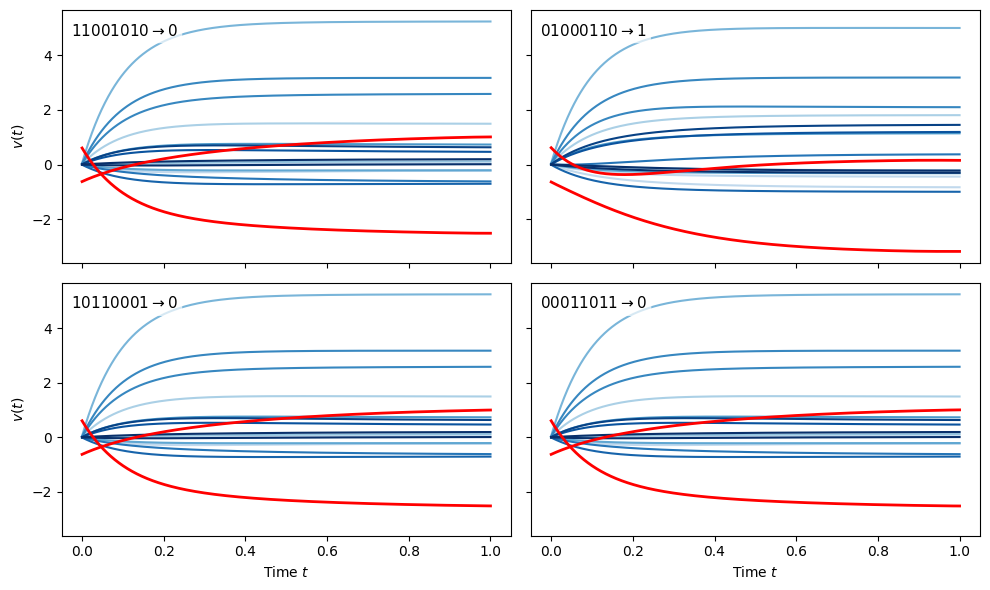

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# Create the colormap
n_lines = traj["V"].shape[-1]
cmap = cm.get_cmap("Blues", n_lines)
colors = cmap(jnp.linspace(0.2, 1.0, n_lines))  # start from lighter blue

for i in range(4):
    visible_traj = traj["V"][:, i, :]  # (n_steps, D)
    logits = logits_from_v(params, visible_traj)
    predicted_token = jnp.argmax(logits[-1], axis=-1)
    ax = axs[i // 2, i % 2]
    ts = jnp.linspace(0, Config.T_final, Config.n_steps)

    # Plot each dimension trajectory in a blue gradient
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, visible_traj[:, d], color=colors[d])

    # plot logits
    ax.plot(
        ts,
        jnp.asarray(logits[:, 0]),
        color="red",
        linestyle="-",
        linewidth=2.0,
        label="Predicted token logit",
    )
    ax.plot(
        ts,
        jnp.asarray(logits[:, 1]),
        color="red",
        linestyle="-",
        linewidth=2.0,
        label="Predicted token logit",
    )

    # Place the text title inside the plot (top-left)
    ax.text(
        0.02,
        0.95,
        f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="left",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="none"
        ),
    )

axs[1, 1].set_xlabel("Time $t$")
axs[1, 0].set_xlabel("Time $t$")
axs[0, 0].set_ylabel("$v(t)$")
axs[1, 0].set_ylabel("$v(t)$")

plt.tight_layout()
plt.show()

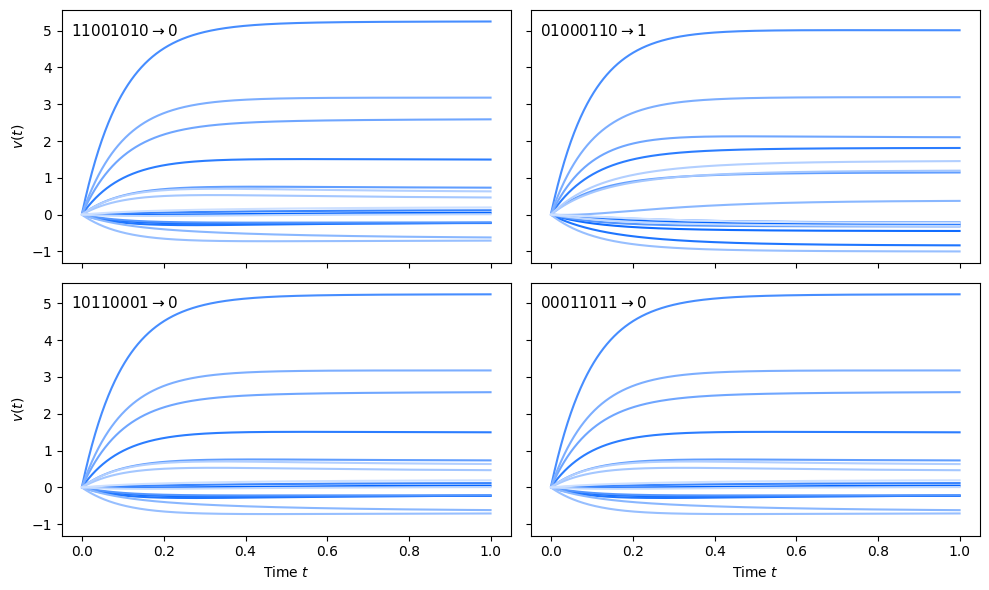

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# --- Generate shades of the same base color (#0364FF) using NumPy floats ---
base_color = np.array(mcolors.to_rgb("#0364FF"))  # (3,) floats in [0,1]
n_lines = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, n_lines)  # blend factor toward white
shades = [
    tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws
]  # list of (r,g,b)

for i in range(4):
    visible_traj = traj["V"][:, i, :]  # (n_steps, D)
    logits = logits_from_v(params, visible_traj[-1])
    predicted_token = jnp.argmax(logits, axis=-1)
    ax = axs[i // 2, i % 2]

    ts = np.linspace(0, Config.T_final, Config.n_steps)  # NumPy for Matplotlib

    # plot each line with a different shade of #0364FF
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, np.asarray(visible_traj[:, d]), color=shades[d])

    # put the title text inside the subplot (top-left)
    ax.text(
        0.02,
        0.95,
        f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="left",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.0, edgecolor="none"
        ),
    )

axs[1, 1].set_xlabel("Time $t$")
axs[1, 0].set_xlabel("Time $t$")
axs[0, 0].set_ylabel("$v(t)$")
axs[1, 0].set_ylabel("$v(t)$")

plt.tight_layout()
plt.show()

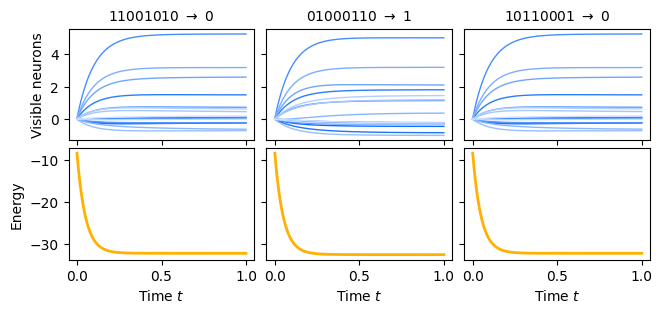

In [6]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# first three contexts
cols = 3
ctx_idx = [0, 1, 2]

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

fig, axs = plt.subplots(
    nrows=2, ncols=cols, figsize=(6.5, 3), sharex=True, sharey="row"
)
for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)
    # prediction from final v(T)
    logits = logits_from_v(params, V_traj[-1])
    pred = int(jnp.argmax(logits))
    # make a neat bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    ax_top.set_ylabel(r"Visible neurons" if c == 0 else None)
    # column label
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- bottom: energy ---
    ax_bot = axs[1, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[1, c].set_xlabel(r"Time $t$")

# tidy layout
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference.pdf", bbox_inches="tight")
plt.show()

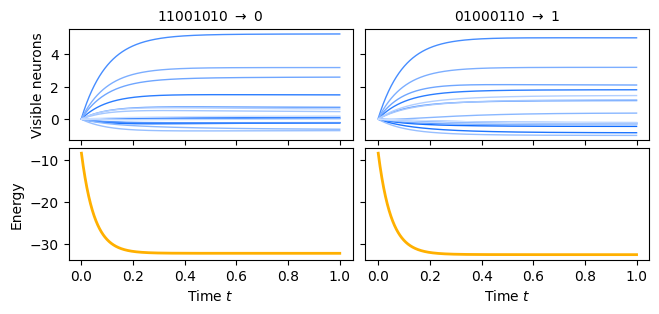

In [7]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# first three contexts
cols = 2
ctx_idx = [0, 1]

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

fig, axs = plt.subplots(
    nrows=2, ncols=cols, figsize=(6.5, 3), sharex=True, sharey="row"
)
for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)
    # prediction from final v(T)
    logits = logits_from_v(params, V_traj[-1])
    pred = int(jnp.argmax(logits))
    # make a neat bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    ax_top.set_ylabel(r"Visible neurons" if c == 0 else None)
    # column label
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- bottom: energy ---
    ax_bot = axs[1, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[1, c].set_xlabel(r"Time $t$")

# tidy layout
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference2.pdf", bbox_inches="tight")
plt.show()

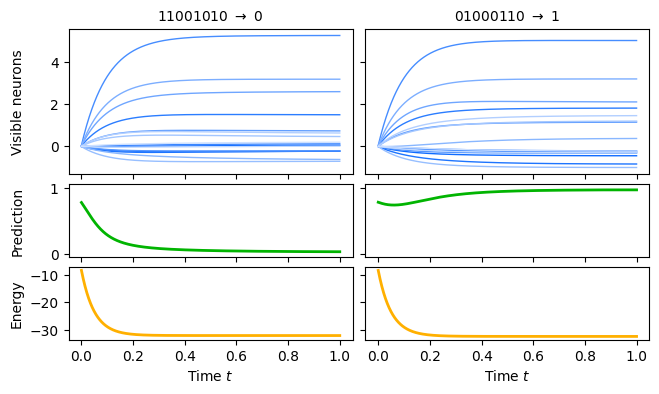

In [8]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# contexts to show
ctx_idx = [0, 1]
cols = len(ctx_idx)

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

# 3 rows: visibles / prediction / energy
fig, axs = plt.subplots(
    nrows=3,
    ncols=cols,
    figsize=(6.5, 3.8),
    sharex=True,
    sharey="row",
    gridspec_kw={"height_ratios": [2, 1, 1]},  # <-- make middle thinner
)

for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)

    # logits over the whole trajectory: shape (n_steps, C)
    logits_traj = np.asarray(logits_from_v(params, V_traj))
    # prediction from final v(T)
    pred = int(np.argmax(logits_traj[-1]))

    # softmax over classes at each time
    logits_shift = logits_traj - logits_traj.max(axis=-1, keepdims=True)
    exp_logits = np.exp(logits_shift)
    probs = exp_logits / exp_logits.sum(axis=-1, keepdims=True)

    # probability that output is class "1"
    p1_traj = probs[:, 1]  # assumes class-1 is index 1

    # bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    if c == 0:
        ax_top.set_ylabel(r"Visible neurons", labelpad=18)
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- middle: prediction probability ---
    ax_mid = axs[1, c]
    ax_mid.plot(ts, p1_traj, linewidth=2.0, color="#01B401")
    ax_mid.set_ylim(-0.05, 1.05)
    if c == 0:
        ax_mid.set_ylabel(r"Prediction", labelpad=18)  # p(y=1)
    ax_mid.set_yticks([0.0, 1.0])

    # --- bottom: energy ---
    ax_bot = axs[2, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[2, c].set_xlabel(r"Time $t$")
    # axs[2, c].set_xlim(-0.01, 0.5)
    # disable borders
    # for r in range(3):
    #     axs[r, c].spines['top'].set_visible(False)
    #     axs[r, c].spines['right'].set_visible(False)

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference_with_prediction.pdf", bbox_inches="tight")
plt.show()